# Loading Modules

In [3]:
%matplotlib inline
from scipy import interp
import seaborn as sns
import numpy as np
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_recall_curve, roc_curve, auc
from sklearn.cross_validation import train_test_split, cross_val_score, KFold, StratifiedKFold
from patsy import dmatrices
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.grid_search import GridSearchCV
#import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

In [4]:
def prob_adjusted_outcome(model_probabilities,threshold):
    y_adjusted=[]
    for prob in model_probabilities:
        if prob[1] > threshold:
            y_adjusted.append(True)
        else:
            y_adjusted.append(False)
    return y_adjusted

# Loading Dataset and Reordering Data

In [5]:
filename='ATA_data.csv'
filename2='ATA2_data.csv'


df = pd.read_csv(filename)
df=df.drop('Unnamed: 0',1)

df2 = pd.read_csv(filename2)
df2 = df2.drop('Unnamed: 0',1)

In [6]:
df_com=pd.concat([df,df2])

In [7]:
np.mean(df_com['installed'])

0.00045545725525535932

In [8]:

cats_to_keep=['entertainment', 'games', 'lifestyle', 'music', 'photography', 'productivity', 
             'social_networking', 'sports', 'travel', 'utilities']

df_com=df_com[df_com.app_type.isin(cats_to_keep)]

#### Taking interesting features

In [9]:
cols_to_keep=['installed', 'creative_id','clicked','impression','app_type','weekday','hours','model','country','publisher_name','language','app_name']
filtered_df=df_com[cols_to_keep]

### Downsampling

In [10]:
ratio=np.mean(df_com['installed'])

In [11]:
#Downsampling by target downsample rate
TotalData=100000
Fsamples=int(np.round(TotalData*(1-ratio)))

In [12]:
False_df=filtered_df[filtered_df['installed'] == False]
Truth_df=filtered_df[filtered_df['installed'] == True]

df2_false=resample(False_df, n_samples=Fsamples, random_state=0, replace = False)
df2_truth=resample(Truth_df, n_samples=TotalData-Fsamples, random_state=0, replace = False)
# Merge the downsampled False with total True outcomes
less_imbalance=pd.concat([df2_false,df2_truth])

In [13]:
less_imbalance.shape

(100000, 12)

In [14]:
y_com,X_com = dmatrices('installed ~ hours + C(weekday) + C(app_type) + C(country) + C(model) +C(publisher_name) + C(language) + C(app_name)'
               ,less_imbalance, return_type='dataframe'
               )

In [15]:
y_com=np.ravel(y_com.iloc[:,1:])

In [16]:
yy=y_com

In [17]:
XX=np.array(X_com)

In [18]:
yy

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

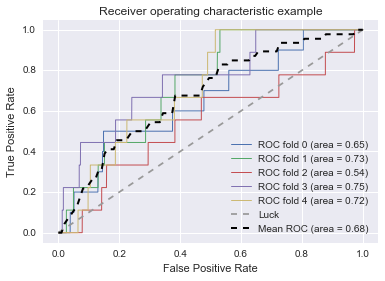

In [33]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(yy, n_folds=5)
classifier = LogisticRegression(fit_intercept=False, class_weight='balanced')

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
class_score = 0
for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(XX[train], yy[train]).predict_proba(XX[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(yy[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if roc_auc - class_score > 0:
        class_score = roc_auc
        better_classifier = classifier
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [20]:
better_classifier

LogisticRegression(C=1.0, class_weight='auto', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

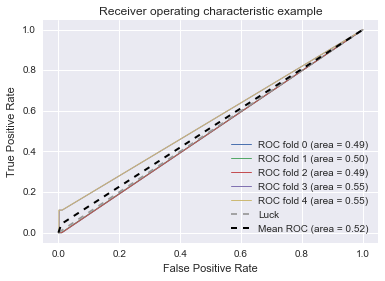

In [36]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(yy, n_folds=5)
classifier = RandomForestClassifier(n_jobs = 2, class_weight = 'auto', n_estimators=100)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(XX[train], yy[train]).predict_proba(XX[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(yy[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_com,y_com, test_size=0.3, random_state=0)

### Logistic Regression

In [38]:
modelLogR2 = LogisticRegression(class_weight='balanced',fit_intercept=False);
modelLogR2.fit(X_train, y_train);

In [39]:
#Use Training Set to verify if model is learning anything
verify_train = modelLogR2.predict(X_train)
prob_train = modelLogR2.predict_proba(X_train)
recall_score(y_train,verify_train)

1.0

In [40]:
#metrics for recall and confusion matrix

print confusion_matrix(y_train, verify_train, labels=[True, False]).transpose()
print classification_report(y_train, verify_train)

[[   36  9640]
 [    0 60324]]
             precision    recall  f1-score   support

        0.0       1.00      0.86      0.93     69964
        1.0       0.00      1.00      0.01        36

avg / total       1.00      0.86      0.93     70000



In [41]:
#Prediction using test set
predictedLR2 = modelLogR2.predict(X_test)
probLR2 = modelLogR2.predict_proba(X_test)
recall_score(y_test,predictedLR2)

0.29999999999999999

In [42]:
probLR2

array([[  9.99210336e-01,   7.89663770e-04],
       [  9.93295218e-01,   6.70478227e-03],
       [  3.65649258e-01,   6.34350742e-01],
       ..., 
       [  9.98680821e-01,   1.31917897e-03],
       [  9.99999710e-01,   2.89547649e-07],
       [  9.99989311e-01,   1.06885853e-05]])

In [43]:
#metrics for recall and confusion matrix

cm = confusion_matrix(y_test, predictedLR2, labels=[True, False]).transpose()
print cm
print classification_report(y_test, predictedLR2)

[[    3  4247]
 [    7 25743]]
             precision    recall  f1-score   support

        0.0       1.00      0.86      0.92     29990
        1.0       0.00      0.30      0.00        10

avg / total       1.00      0.86      0.92     30000



In [44]:
probLR2[:,1].sum()/y_test.sum()

418.22310911807369

In [45]:
probLR2.sum()/y_test.sum()

3000.0

In [46]:
X_com.shape

(100000, 1507)

In [47]:
rm=[LogisticRegression(fit_intercept=False)]
cvs=5
model_aucs=np.empty((len(rm),cvs))
model_recalls=np.empty((len(rm),cvs))
model_precision=np.empty((len(rm),cvs))

for i,models in enumerate(rm):
    
    model_recalls[i,:] = cross_val_score(models, X_com, y_com, scoring = 'recall', cv = cvs)
    model_precision[i,:] = cross_val_score(models, X_com, y_com, scoring = 'precision', cv = cvs)
    model_aucs[i,:] = cross_val_score(models, X_com, y_com, scoring = 'roc_auc', cv = cvs)

In [48]:
summary_matrices = np.empty((6,len(rm)))
summary_matrices[0, :] = np.mean(model_recalls, axis=1)
summary_matrices[1, :] = np.std(model_recalls, axis = 1)
summary_matrices[2, :] = np.mean(model_precision, axis=1)
summary_matrices[3, :] = np.std(model_precision, axis = 1)
summary_matrices[4, :] = np.mean(model_aucs, axis=1)
summary_matrices[5, :] = np.std(model_aucs, axis = 1)
print summary_matrices

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.66932104]
 [ 0.06348148]]


In [49]:
summary_df=pd.DataFrame(summary_matrices)

In [50]:
summary_df

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.669321
5,0.063481


### Random Forests

In [70]:
modelRandomForest= RandomForestClassifier(class_weight='balanced')
modelRandomForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [72]:
feature_names = X_train.columns

In [74]:
feature_names

(1507,)

In [52]:
importances = modelRandomForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelRandomForest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [53]:
indices.shape

(1507,)

In [60]:
len(range(400))

400

In [68]:
modelRandomForest.feature_importances_

array([ 0.        ,  0.01585746,  0.02383725, ...,  0.        ,
        0.        ,  0.11744173])

In [61]:
len(importances[indices][0:400])

400

In [69]:
modelRandomForest.

1507

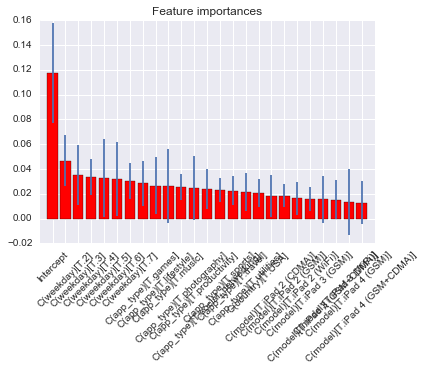

In [77]:
index_limit = 25
plt.figure()
plt.title("Feature importances")
plt.bar(range(index_limit), importances[indices][0:index_limit],
       color="r", yerr=std[indices][0:index_limit], align="center")
plt.xticks(range(index_limit), feature_names[0:index_limit], rotation=45)
plt.xlim([-1, index_limit])
plt.show()

In [78]:
# Random Forest Predictions
predictedRF = modelRandomForest.predict(X_test)
probsRF = modelRandomForest.predict_proba(X_test)

In [79]:
probsRF

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [80]:
# Look at precision/recall and confusion matrix

print confusion_matrix(y_test,predictedRF, labels=[True, False]).transpose()
print classification_report(y_test,predictedRF)

[[    0    12]
 [   10 29978]]
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     29990
        1.0       0.00      0.00      0.00        10

avg / total       1.00      1.00      1.00     30000



In [88]:
probs.sum()/y_test.sum()

NameError: name 'probs' is not defined

In [89]:
def prob_class_outcome(model_probabilities,select_class):
    prob_class=[]
    for prob in model_probabilities:
            prob_class.append(prob[select_class])
    return prob_class

In [90]:
probRF1=prob_class_outcome(probsRF,1)

(array([  2.98780000e+04,   6.80000000e+01,   1.60000000e+01,
          2.00000000e+00,   1.20000000e+01,   1.20000000e+01,
          7.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([ 0.        ,  0.08982547,  0.17965094,  0.26947641,  0.35930188,
         0.44912734,  0.53895281,  0.62877828,  0.71860375,  0.80842922,
         0.89825469]),
 <a list of 10 Patch objects>)

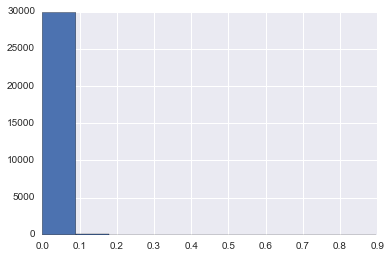

In [91]:
plt.hist(probRF1)

In [92]:
np.where(probRF1 == 0.0)

(array([], dtype=int64),)